## Stacked Convolutional Recurrent Neural Networks

In [1]:
import os
os.environ["PYTHONHASHSEED"] = "0"

import random as rn
rn.seed(1254)

import numpy as np
np.random.seed(1515)

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import librosa, librosa.display, IPython.display as ipd
from tqdm import tqdm
import glob
import pandas as pd
import h5py
from sklearn import preprocessing
import pickle

In [2]:
plt.rcParams['figure.figsize'] = (14, 6)

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import tensorflow as tf
tf.set_random_seed(2)

config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1 
)

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(graph= tf.get_default_graph(), config=config) 
    
import keras 
from keras import backend as K
K.set_session(sess)  # set this TensorFlow session as the default session for Keras

from keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Reshape, Bidirectional
from keras.layers.wrappers import TimeDistributed
from keras.layers import Dense, Flatten
from keras.layers.core import Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [4]:
#SET PATHS
dataspace = '/vol/vssp/datasets/audio01/UrbanSound8K/audio/'
projectspace = '/vol/vssp/AcousticEventsDetection/DLGdansk/UrbanSound/'

metadatafile = '/vol/vssp/datasets/audio01/UrbanSound8K/metadata/UrbanSound8K.csv'
metadata = pd.read_csv(metadatafile)

hdf5_path = os.path.join(projectspace,'dataset.hdf5') 
modelfolder = os.path.join(projectspace,'models')
scalerpath = os.path.join(projectspace,'scaler.pkl')

In [5]:
# LOAD DATA
hf = h5py.File(hdf5_path, 'r')
X_train = np.array(hf.get('X_train') )
y_train = np.array(hf.get('y_train'))
X_val =  np.array(hf.get('X_val'))
y_val= np.array(hf.get('y_val'))
X_test = np.array(hf.get('X_test'))
y_test = np.array(hf.get('y_test'))

n_features= hf.get('n_features').value
n_frames=hf.get('max_length_samp').value
label_list= hf.get('label_list').value

In [6]:
# SCALE THE DATA
scaler=pickle.load(open(scalerpath, 'rb'))

X_train_scaled = [scaler.transform(x.T) for x in X_train]
X_val_scaled = [scaler.transform(x.T) for x in X_val]
X_test_scaled = [scaler.transform(x.T) for x in X_test]

# CHANGE DIMENSION TO FIT KERAS
X_train = np.expand_dims(X_train_scaled, 3)
X_val = np.expand_dims(X_val_scaled, 3)
X_test = np.expand_dims(X_test_scaled, 3)

In [7]:
def build_crnn(n_frames=n_frames, n_features=n_features,  n_filters_cnn=48,
                     filter_size_cnn=(5, 5), pool_size_cnn=(2,2),
                     n_classes=10):

    # INPUT
    x = Input(shape=(n_frames, n_features,  1), dtype='float32')

    # CONV 1
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='same', kernel_regularizer=l2(0.01),
               activation='relu')(x)
    y = MaxPooling2D(pool_size=(1,2), strides=None, padding='same')(y)
    y = BatchNormalization()(y)

    # CONV 2
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='same', kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=(1,2), strides=None, padding='same')(y)
    y = BatchNormalization()(y)

    # CONV 3
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='same', kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=(1,2), strides=None, padding='same')(y)
    y = BatchNormalization()(y)
    
    # CONV 4
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='same', kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=(1,5), strides=None, padding='same')(y)
    y = BatchNormalization()(y)
    
    y = Reshape((n_frames, n_filters_cnn))(y)
    
    #y = Dropout(0.5)(y)
    y= LSTM(120)(y)
    #y = Dropout(0.5)(y)
    #y = Dense(n_dense_cnn, activation='relu')(y)

    #y = Dropout(0.5)(y)
    y = Dense(n_classes, activation='sigmoid')(y)

    m = Model(inputs=x, outputs=y)
    return m

In [8]:
m = build_crnn(n_features=40,)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 173, 40, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 173, 40, 48)       1248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 173, 20, 48)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 173, 20, 48)       192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 173, 20, 48)       57648     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 173, 10, 48)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 173, 10, 48)       192       
__________

In [9]:
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model_checkpoint = ModelCheckpoint(
    os.path.join(modelfolder, 'crnn_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.hdf5'),
    monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
callbacks = [early_stopping, model_checkpoint]

history = m.fit(x=X_train, y=y_train, batch_size=130,
                    epochs=200, verbose=True,
                    validation_split=0.0,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val), shuffle=True)

Train on 7079 samples, validate on 816 samples
Epoch 1/200
7079/7079 [==============================] - 31s 4ms/step - loss: 2.7410 - acc: 0.3390 - val_loss: 2.9699 - val_acc: 0.1667
Epoch 2/200
7079/7079 [==============================] - 24s 3ms/step - loss: 1.9749 - acc: 0.4889 - val_loss: 3.1054 - val_acc: 0.1569
Epoch 3/200
7079/7079 [==============================] - 25s 3ms/step - loss: 1.7416 - acc: 0.5577 - val_loss: 3.2891 - val_acc: 0.1005
Epoch 4/200
7079/7079 [==============================] - 24s 3ms/step - loss: 1.8575 - acc: 0.5208 - val_loss: 2.9804 - val_acc: 0.2794
Epoch 5/200
7079/7079 [==============================] - 24s 3ms/step - loss: 1.7433 - acc: 0.5745 - val_loss: 2.8268 - val_acc: 0.2194
Epoch 6/200
7079/7079 [==============================] - 25s 3ms/step - loss: 1.7529 - acc: 0.5730 - val_loss: 2.6790 - val_acc: 0.3676
Epoch 7/200
7079/7079 [==============================] - 24s 3ms/step - loss: 1.6107 - acc: 0.6176 - val_loss: 2.4153 - val_acc: 0.4252
E

7079/7079 [==============================] - 24s 3ms/step - loss: 0.8179 - acc: 0.8822 - val_loss: 1.7203 - val_acc: 0.6654
Epoch 61/200
7079/7079 [==============================] - 24s 3ms/step - loss: 0.6761 - acc: 0.9138 - val_loss: 2.0102 - val_acc: 0.6299
Epoch 62/200
7079/7079 [==============================] - 24s 3ms/step - loss: 0.6455 - acc: 0.9121 - val_loss: 2.0257 - val_acc: 0.6324
Epoch 63/200
7079/7079 [==============================] - 24s 3ms/step - loss: 0.6387 - acc: 0.9090 - val_loss: 1.7968 - val_acc: 0.6507
Epoch 64/200
7079/7079 [==============================] - 25s 4ms/step - loss: 0.6189 - acc: 0.9087 - val_loss: 1.9386 - val_acc: 0.6213
Epoch 65/200
7079/7079 [==============================] - 25s 3ms/step - loss: 0.5740 - acc: 0.9178 - val_loss: 1.7630 - val_acc: 0.6740
Epoch 66/200
7079/7079 [==============================] - 24s 3ms/step - loss: 0.5727 - acc: 0.9155 - val_loss: 1.9482 - val_acc: 0.6532
Epoch 67/200
7079/7079 [==============================

Epoch 120/200
7079/7079 [==============================] - 21s 3ms/step - loss: 0.6098 - acc: 0.9240 - val_loss: 1.8777 - val_acc: 0.6814
Epoch 121/200
7079/7079 [==============================] - 20s 3ms/step - loss: 0.5346 - acc: 0.9383 - val_loss: 2.0196 - val_acc: 0.6520
Epoch 122/200
7079/7079 [==============================] - 21s 3ms/step - loss: 0.4615 - acc: 0.9547 - val_loss: 2.2277 - val_acc: 0.6189
Epoch 123/200
7079/7079 [==============================] - 22s 3ms/step - loss: 0.4425 - acc: 0.9515 - val_loss: 1.8448 - val_acc: 0.6765
Epoch 124/200
7079/7079 [==============================] - 20s 3ms/step - loss: 0.4122 - acc: 0.9592 - val_loss: 1.8133 - val_acc: 0.6630
Epoch 125/200
7079/7079 [==============================] - 21s 3ms/step - loss: 0.3925 - acc: 0.9593 - val_loss: 1.6824 - val_acc: 0.6826
Epoch 126/200
7079/7079 [==============================] - 22s 3ms/step - loss: 0.3408 - acc: 0.9708 - val_loss: 2.1459 - val_acc: 0.6348
Epoch 127/200
7079/7079 [=========

In [11]:
prediction = m.predict(X_test, batch_size=130, verbose=1)
y_predict=np.array([ np.argmax(p) for p in prediction])
y_test_label = np.array([np.argmax(y) for y in y_test])

837/837 [==============================] - 1s 1ms/step


Accuracy: 0.60


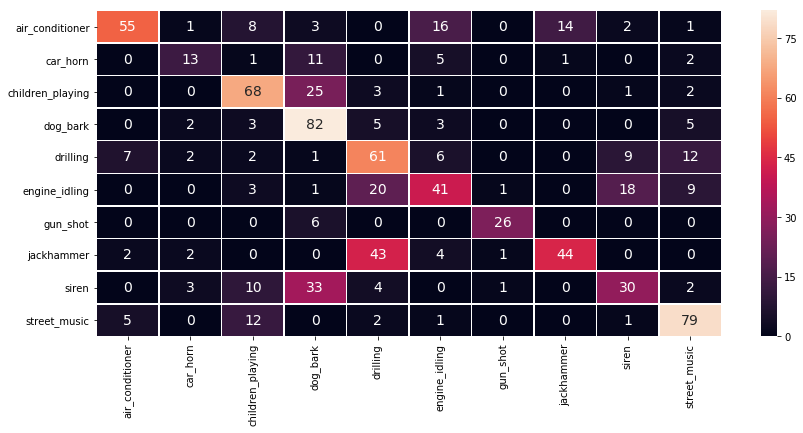

In [12]:
from sklearn.metrics import confusion_matrix

acc = np.sum(y_test_label==y_predict) / float(len(y_test_label))
print('Accuracy: {:.2f}'.format(acc))

cm = confusion_matrix(y_test_label, y_predict )
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, yticklabels=label_list,xticklabels=label_list)

In [13]:
def build_crnn2(n_features=n_features, n_frames=n_frames, n_filters_cnn=48,
                     filter_size_cnn=(3, 3), pool_size_cnn=(2,2),
                     n_classes=10):

    # INPUT
    x = Input(shape=( n_frames, n_features, 1), dtype='float32')

    # CONV 1
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid', kernel_regularizer=l2(0.01),
               activation='relu')(x)
    y = MaxPooling2D(pool_size=pool_size_cnn, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    # CONV 2
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid',kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=pool_size_cnn, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    # CONV 3
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid',kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=pool_size_cnn, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)
    
    y = TimeDistributed(Flatten())(y)
    
    #y = Reshape((n_filters_cnn,n_frames))(y)
    
    y = Dropout(0.5)(y)
    y= LSTM(120)(y)
    #y = Dropout(0.5)(y)
    #y = Dense(n_dense_cnn, activation='relu')(y)

    y = Dropout(0.5)(y)
    y = Dense(n_classes, activation='sigmoid')(y)

    m = Model(inputs=x, outputs=y)
    return m

In [14]:
m = build_crnn2(n_features=40,)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 173, 40, 1)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 171, 38, 48)       480       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 85, 19, 48)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 85, 19, 48)        192       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 83, 17, 48)        20784     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 41, 8, 48)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 41, 8, 48)         192       
__________

In [15]:
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
model_checkpoint = ModelCheckpoint(
    os.path.join(modelfolder, 'crnn2_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.hdf5'),
    monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
callbacks = [early_stopping, model_checkpoint]

history = m.fit(x=X_train, y=y_train, batch_size=130,
                    epochs=200, verbose=True,
                    validation_split=0.0,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val), shuffle=True)

Train on 7079 samples, validate on 816 samples
Epoch 1/200
7079/7079 [==============================] - 7s 994us/step - loss: 2.6293 - acc: 0.3464 - val_loss: 2.9427 - val_acc: 0.2463
Epoch 2/200
7079/7079 [==============================] - 4s 579us/step - loss: 1.8821 - acc: 0.5128 - val_loss: 3.7713 - val_acc: 0.1127
Epoch 3/200
7079/7079 [==============================] - 5s 661us/step - loss: 1.4686 - acc: 0.6183 - val_loss: 3.9921 - val_acc: 0.1642
Epoch 4/200
7079/7079 [==============================] - 5s 640us/step - loss: 1.2228 - acc: 0.7001 - val_loss: 4.0007 - val_acc: 0.1654
Epoch 5/200
7079/7079 [==============================] - 5s 649us/step - loss: 0.9843 - acc: 0.7714 - val_loss: 3.9390 - val_acc: 0.1299
Epoch 6/200
7079/7079 [==============================] - ETA: 0s - loss: 0.8580 - acc: 0.8107- ETA: 0s - loss: 0.8610 - - 4s 581us/step - loss: 0.8596 - acc: 0.8099 - val_loss: 4.0716 - val_acc: 0.1679
Epoch 7/200
7079/7079 [==============================] - 4s 612us/

7079/7079 [==============================] - 4s 624us/step - loss: 0.1859 - acc: 0.9775 - val_loss: 1.8725 - val_acc: 0.7451
Epoch 60/200
7079/7079 [==============================] - 4s 599us/step - loss: 0.2199 - acc: 0.9686 - val_loss: 1.6598 - val_acc: 0.7292
Epoch 61/200
7079/7079 [==============================] - 4s 561us/step - loss: 0.1891 - acc: 0.9771 - val_loss: 1.5208 - val_acc: 0.7537
Epoch 62/200
7079/7079 [==============================] - 4s 616us/step - loss: 0.2063 - acc: 0.9737 - val_loss: 1.5934 - val_acc: 0.7169
Epoch 63/200
7079/7079 [==============================] - 4s 615us/step - loss: 0.1765 - acc: 0.9812 - val_loss: 1.9297 - val_acc: 0.7206
Epoch 64/200
7079/7079 [==============================] - 5s 648us/step - loss: 0.2148 - acc: 0.9691 - val_loss: 1.6134 - val_acc: 0.7463
Epoch 65/200
7079/7079 [==============================] - 4s 590us/step - loss: 0.2202 - acc: 0.9685 - val_loss: 1.6287 - val_acc: 0.7377
Epoch 66/200
7079/7079 [=======================

In [17]:
prediction = m.predict(X_test, batch_size=130, verbose=1)
y_predict=np.array([ np.argmax(p) for p in prediction])
y_test_label = np.array([np.argmax(y) for y in y_test])

837/837 [==============================] - 1s 642us/step


Accuracy: 0.75


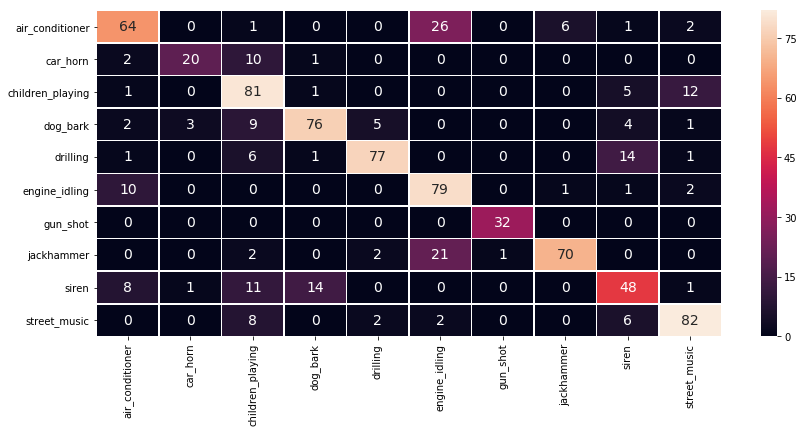

In [20]:
from sklearn.metrics import confusion_matrix

acc = np.sum(y_test_label==y_predict) / float(len(y_test_label))
print('Accuracy: {:.2f}'.format(acc))

cm = confusion_matrix(y_test_label, y_predict )
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, yticklabels=label_list,xticklabels=label_list)